In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02)
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = PLS.Variable('Bp1', varMin=.1, varMax=.45)
Bp2 = PLS.Variable('Bp2', varMin=.1, varMax=.45)
Bp3 = PLS.Variable('Bp3', varMin=.1, varMax=.45)
Bp4 = PLS.Variable('Bp4', varMin=.1, varMax=.45)

rp1 =.03# PLS.Variable('rp1', varMin=.005, varMax=.03)
rp2 =.03# PLS.Variable('rp2', varMin=.005, varMax=.03)
rp3 =.03# PLS.Variable('rp3', varMin=.005, varMax=.03)
rp4 =.03# PLS.Variable('rp4', varMin=.005, varMax=.03)

#s = PLS.Variable('s', varMin=.005, varMax=.03)

r0=1
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=test)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.05)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.05)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.05)
PLS.end_Lattice()

Lattice model completed


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


minCost for each thread:  [4.00000049 1.82083195 4.         1.88082989 1.58165186 1.80408557
 1.7336374  1.831429   1.77356955 1.57351234 1.53243706 1.71100646]


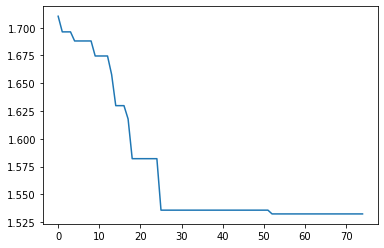

[0.5        0.02892555 0.5        0.4822316  0.12401952 0.44337053
 0.22180048 0.42016329 0.8991622  1.49872565 0.19842905 0.12389675
 0.04908461] 1.5324370618063006
percent particles surviving (x,y): 19.7, 20.6
[0.5        0.02892555 0.5        0.4822316  0.12401952 0.44337053
 0.22180048 0.42016329 0.8991622  1.49872565 0.19842905 0.12389675
 0.04908461] 1.5324370618063006
done
Total time 2 minutes and 26 seconds


In [2]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(mut=.75, crossPop=.7, iterations=100, popPerDim=20,strategy='best/1')

In [23]:
q0=minimizer.sol.geneticSolX
def probe_Vicinity(q,floorPlan):
  probePointsList=[]
  probeSize=1e-3
  i=0
  for x in q:
    temp=np.zeros(q.shape)
    temp[i]=probeSize
    probePointsList.append(temp+q)
    temp=np.zeros(q.shape)
    temp[i]=-probeSize
    probePointsList.append(temp+q)
    i+=1
  maxVal=0
  j=0
  print(q)
  for probePoint in probePointsList:
    cost=minimizer.cost_Function(probePoint,False,floorPlan)
    print(cost,(j+1+1)//2)
    j+=1
floorPlan = FloorPlan(minimizer.PLS)    
probe_Vicinity(q0,floorPlan)

[0.5        0.02892555 0.5        0.4822316  0.12401952 0.44337053
 0.22180048 0.42016329 0.8991622  1.49872565 0.19842905 0.12389675
 0.04908461]
1.5324436784505753 1
1.536524391268229 1
1.5323854947487916 2
1.540689673888099 2
1.5358193785675887 3
1.5147015341267531 3
1.5359369637236349 4
1.5217672597495784 4
1.5286424076482032 5
1.5406489056698234 5
1.5324340156176468 6
1.5324401411633823 6
1.5436384786958237 7
1.5189698543638566 7
1.536054871864349 8
1.5293652123361614 8
1.532432358506136 9
1.5324420177052547 9
1.5324263612161448 10
1.532448141413539 10
1.5398248948528335 11
4.0733472876614485 11
4.2186775786495225 12
1.543238487999497 12
1.5332847435979982 13
1.5364860921866745 13


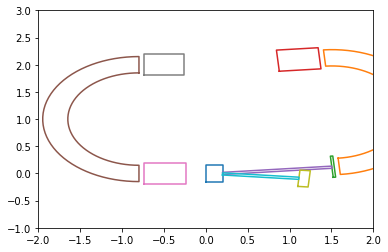

In [25]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)

In [28]:
Bp=1
rp=.02
r=.01
2*r*Bp/rp**2

50.0

In [25]:
from shapely.geometry import Point
from shapely.geometry import Polygon
import time

temp=Point(.5,.6)
temp1=Polygon([[0,0],[1,0],[2,0],[1,1],[.5,2],[0,1]])
t=time.time()
for i in range(int(1e5)):
    temp1.intersects(temp)
print(1e6*(time.time()-t)/1e5)

34.60721969604492
